<a href="https://colab.research.google.com/github/ogut77/WordFreqCountSpark/blob/master/MovieLensGenreCount.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://ftp.itu.edu.tr/Mirror/Apache/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
from pyspark import SparkContext
sc = SparkContext.getOrCreate()


In [0]:
import urllib.request
import pandas as pd 
import zipfile
import os
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

import os

small=urllib.request.urlretrieve('http://files.grouplens.org/datasets/movielens/ml-latest-small.zip','/content/drive/My Drive/small.zip')
big=urllib.request.urlretrieve('http://files.grouplens.org/datasets/movielens/ml-latest.zip','/content/drive/My Drive/big.zip')

with zipfile.ZipFile('/content/drive/My Drive/small.zip', "r") as z:
   z.extractall('/content/drive/My Drive/')
    
with zipfile.ZipFile('/content/drive/My Drive/big.zip', "r") as z:
   z.extractall('/content/drive/My Drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
movies= spark.read.format("csv").option("header", "true").load("/content/drive/My Drive/ml-latest/movies.csv")
movies.take(3)


[Row(movieId='1', title='Toy Story (1995)', genres='Adventure|Animation|Children|Comedy|Fantasy'),
 Row(movieId='2', title='Jumanji (1995)', genres='Adventure|Children|Fantasy'),
 Row(movieId='3', title='Grumpier Old Men (1995)', genres='Comedy|Romance')]

In [42]:
ratings= spark.read.format("csv").option("header", "true").load("/content/drive/My Drive/ml-latest/ratings.csv")
 ratings.take(3)   



[Row(userId='1', movieId='307', rating='3.5', timestamp='1256677221'),
 Row(userId='1', movieId='481', rating='3.5', timestamp='1256677456'),
 Row(userId='1', movieId='1091', rating='1.5', timestamp='1256677471')]

In [45]:
mergedDF = ratings.join(movies, movies.movieId == ratings.movieId,how='left') # Could also use  pd.merge(ratings,movies,on=['movieId'],how='left')
mergedDF.head(5)

[Row(userId='1', movieId='307', rating='3.5', timestamp='1256677221', movieId='307', title='Three Colors: Blue (Trois couleurs: Bleu) (1993)', genres='Drama'),
 Row(userId='1', movieId='481', rating='3.5', timestamp='1256677456', movieId='481', title='Kalifornia (1993)', genres='Drama|Thriller'),
 Row(userId='1', movieId='1091', rating='1.5', timestamp='1256677471', movieId='1091', title="Weekend at Bernie's (1989)", genres='Comedy'),
 Row(userId='1', movieId='1257', rating='4.5', timestamp='1256677460', movieId='1257', title='Better Off Dead... (1985)', genres='Comedy|Romance'),
 Row(userId='1', movieId='1449', rating='4.5', timestamp='1256677264', movieId='1449', title='Waiting for Guffman (1996)', genres='Comedy')]

In [46]:
mergedDF.count()

27753444

In [50]:
temp=mergedDF.rdd
genres=temp.map(lambda tokens: (tokens[6])).cache()
genres.take(3)


['Drama', 'Drama|Thriller', 'Comedy']

In [51]:
WordsCount=genres.flatMap(lambda line: line.split("|")).map(lambda word: (word, 1))
WordsCount.count()

75198276

In [52]:
DistinctWordsCount=WordsCount.reduceByKey(lambda a,b: a+b)
DistinctWordsCount.count()

20

In [54]:
SortedWordsCount=DistinctWordsCount.map(lambda a: (a[1], a[0])).sortByKey()
#print most frequent 20 words
SortedWordsCount.top(20)


[(12191048, 'Drama'),
 (9999184, 'Comedy'),
 (8214956, 'Action'),
 (7489628, 'Thriller'),
 (6452309, 'Adventure'),
 (5078478, 'Romance'),
 (4740208, 'Sci-Fi'),
 (4631581, 'Crime'),
 (3118549, 'Fantasy'),
 (2381124, 'Children'),
 (2210388, 'Mystery'),
 (2070791, 'Horror'),
 (1803041, 'Animation'),
 (1426112, 'War'),
 (1109674, 'Musical'),
 (1102179, 'IMAX'),
 (542424, 'Western'),
 (345471, 'Documentary'),
 (272742, 'Film-Noir'),
 (18389, '(no genres listed)')]

In [129]:
SortedWordsCount.collect()
Son=SortedWordsCount.toDF(['Frequency', 'Genre']).toPandas()
Son2=Son.nlargest(20, 'Frequency', keep='first')
Son2.head()

,Frequency,Genre
19,12191048,Drama
18,9999184,Comedy
17,8214956,Action
16,7489628,Thriller
15,6452309,Adventure


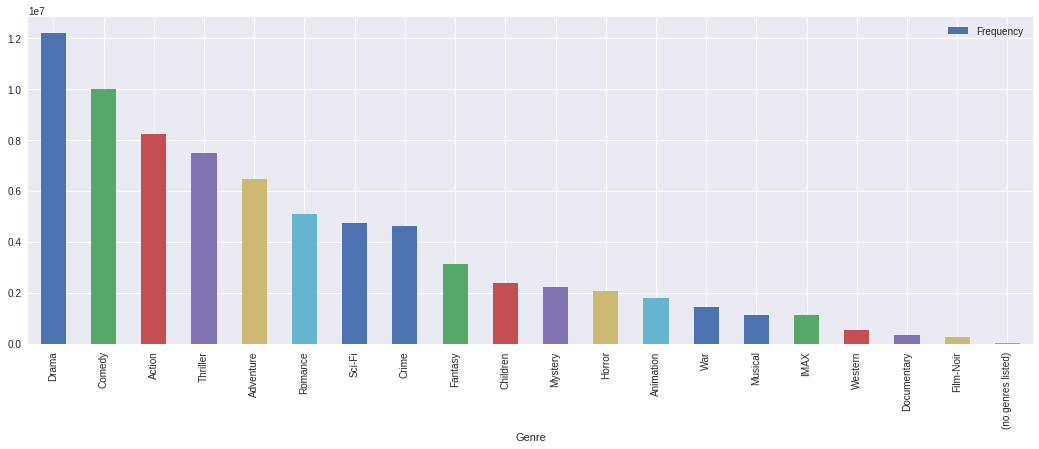

In [127]:
import matplotlib.pyplot as plt
import pandas as pd
Son2.plot(kind='bar',x='Genre', y='Frequency',figsize= (18, 6) )
plt.show()